__author__ = 'chtrinh'

__version__ = '08/09/2020'

__description__ = This script uses the python seaborn package to plot visualizations (https://seaborn.pydata.org/index.html)

Dataset: Video Game Sales

Description: 
- Analyze sales data (units sold) from more than 16,500 games.
- 8 columns & 66,392 records

Fields include:
1. sales rank worldwide - Ranking by worldwide total unit sales
2. title - The game's title
3. platform - Platform of the game's release (e.g. PC, PS4, etc.)
4. release year - Year of the game's release
5. genre - Genre of the game
6. publisher - Publisher of the game
7. region - Region of unit sales
8. units sold -  Units sold (in millions)

https://w.amazon.com/bin/view/Analyticon/2020/VizContest/#HCompetitiontimeline
 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandas.plotting import scatter_matrix
from sqlalchemy.engine import url as sa_url #For Query
from sqlalchemy import create_engine
import psycopg2
import datetime
from collections import Counter #https://pymotw.com/2/collections/counter.html
import numpy as np
import pandas as pd
import urllib
import gzip

df = pd.read_csv("vgsales.csv")
df['Game Title'] = df['title']+ ' /  ' +df['publisher']+ ' / ' + df['genre'] + ' / ' + df['release_year'].astype(str)

## # What are the most popular game genres? 

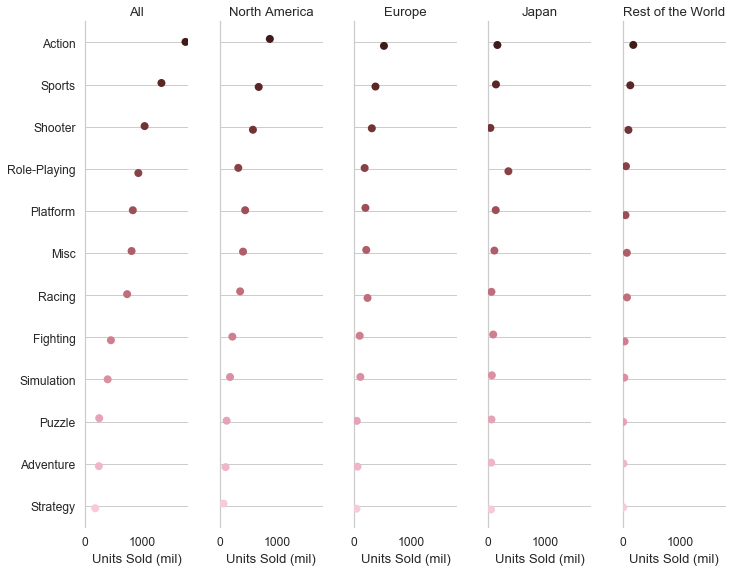

In [69]:
sales_by_genre = (df.pivot_table(values='units_sold'
                                    , index='genre'
                                    , columns='region'
                                    , aggfunc=sum
                                    , margins=True)
                        .sort_values(by='All', ascending=False)
                        .reset_index()
                        .iloc[1:50])
sales_by_genre = sales_by_genre[['genre', 'All', 'North America', 'Europe', 'Japan', 'Rest of the World']]
sns.set(style="whitegrid", font_scale=1.1, context='notebook')
# Make the PairGrid
g = sns.PairGrid(sales_by_genre.sort_values(by="All", ascending=False),
                 x_vars=sales_by_genre.columns[1:], y_vars=["genre"],
                 height=8, aspect=.25)
# Draw a dot plot using the stripplot function
flatui= ["#9b59b6","#3498db","#95a5a6","#e74c3c","#34495e","#2ecc71"]
g.map(sns.stripplot, size=8, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="None")
# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1800), xlabel="Units Sold (mil)", ylabel="")

# Use semantically meaningful titles for the columns
titles = sales_by_genre.columns[1:]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=False, bottom=True)

### 1.a. Role-playing is the most popular game genre in Japan. What role-playing games dominate this market?

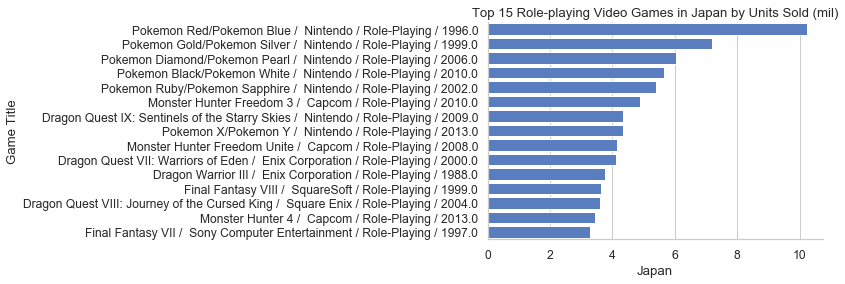

In [46]:
df1a = df[df['genre']=='Role-Playing']
df1ap = df1a.pivot_table(values='units_sold'
                     , index='Game Title'
                     , columns='region'
                     , aggfunc=sum
                     , margins=False).reset_index().sort_values(by='Japan',ascending=False).iloc[:15]
df1ap['other_region']=df1ap['North America']+df1ap['Europe']+df1ap['Rest of the World']
# Plot the units sold

sns.set_color_codes("muted")
sns.barplot(x="Japan", y='Game Title', data=df1ap,
            label="Units Sold (mil)", color="b").set_title('Top 15 Role-playing Video Games in Japan by Units Sold (mil)')

sns.despine(left=False, bottom=False)

## # What are the biggest game publishers by total worldwide units sale?

Text(0.5, 1, 'Top 50 Publishers by Units Sold Worldwide')

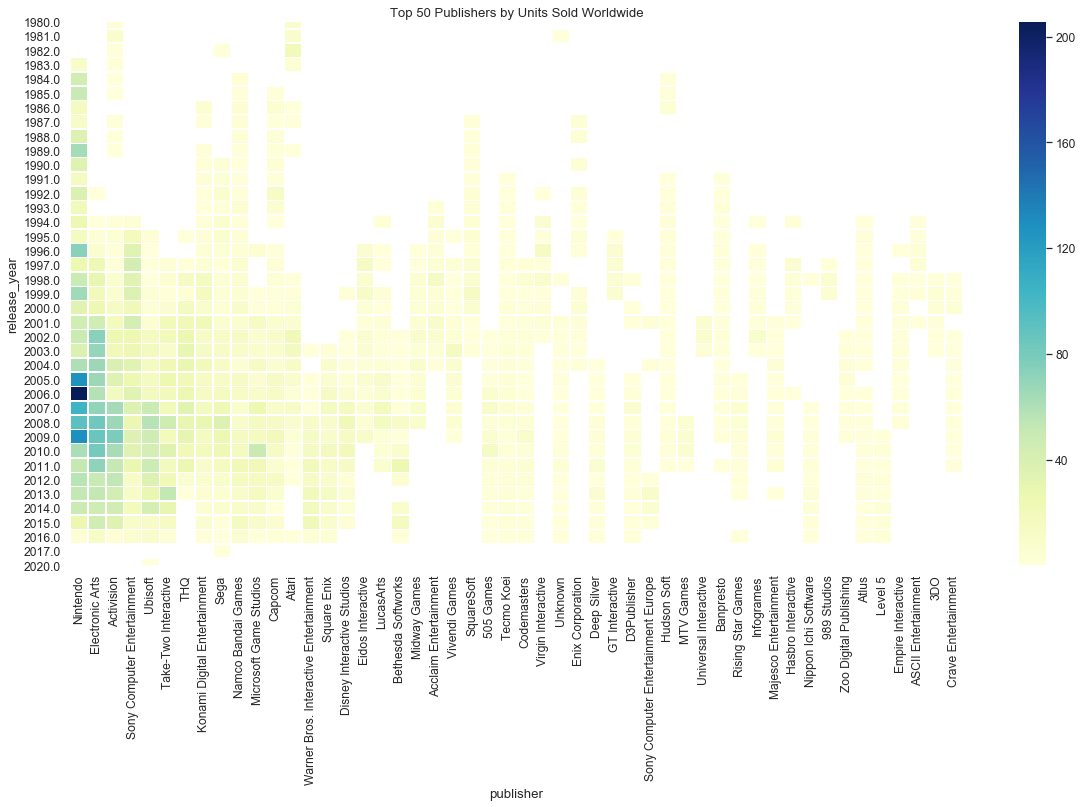

In [71]:
X=50
topX_publisher_by_sales = (df.pivot_table(values='units_sold'
                                    , index='publisher'
                                    , aggfunc=sum)
                        .sort_values(by='units_sold', ascending=False)
                        .reset_index()
                        .iloc[0:X]) 
dfX = df[df['publisher'].isin(topX_publisher_by_sales['publisher'].to_list())]
sales_by_release_and_publisher = dfX.pivot_table(values='units_sold'
                                    , index=['release_year','publisher']
                                    , aggfunc=sum).reset_index().sort_values(by='units_sold',ascending=False).iloc[:1000]
sales_by_release_and_publisher = sales_by_release_and_publisher.pivot("release_year", "publisher", "units_sold")
sales_by_release_and_publisher = sales_by_release_and_publisher.reindex(columns=topX_publisher_by_sales['publisher'].to_list())
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(sales_by_release_and_publisher, annot=False, fmt=".3g", linewidths=.5, ax=ax, cmap='YlGnBu')
plt.title('Top 50 Publishers by Units Sold Worldwide')

### 2.a. Nintendo is one of the oldest publishers and had incredible success with their games released between 2005 and 2009. What titles did they release during this period?

C:\Users\chtrinh\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\chtrinh\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


Text(0.5, 1, 'Sales of Top Nintendo Games Released 2005-2009')

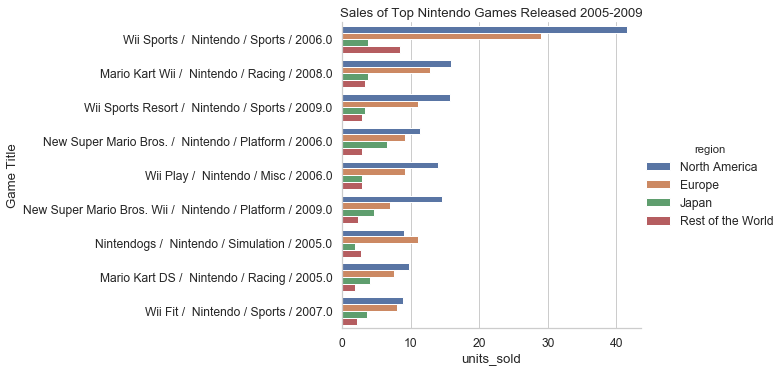

In [55]:
year_list = ['2005', '2006', '2007', '2008', '2009']
df2a = df[(df['publisher']=='Nintendo')&(df['release_year'].isin(year_list))]
df2ap = df2a.pivot_table(values='units_sold'
                     , index='Game Title'
                     , columns='release_year'
                     , aggfunc=sum
                     , margins=True).reset_index().sort_values(by='All', ascending=False).iloc[:10]
dfb = df[df['Game Title'].isin(df2ap['Game Title'].to_list())]
sns.factorplot(x='units_sold', y='Game Title', hue='region', data=dfb, kind='bar', hue_order=['North America', 'Europe', 'Japan', 'Rest of the World'])
plt.title('Sales of Top Nintendo Games Released 2005-2009')

## # What are the most popular video games by units sold per year?

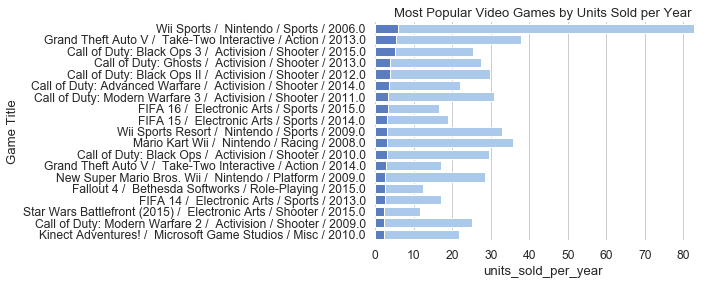

In [57]:
Y='Game Title'
df['years_since_release']=2020-df['release_year']
df['units_sold_per_year']=df['units_sold']/df['years_since_release']
dfY = df.pivot_table(values=['units_sold','years_since_release','units_sold_per_year']
                           , index=Y
                           , aggfunc={'units_sold':sum, 'years_since_release':np.mean, 'units_sold_per_year':np.sum}
                           ).reset_index().sort_values(by='units_sold_per_year', ascending=False).iloc[1:20]

# Plot the units sold
sns.set_color_codes("pastel")
sns.barplot(x="units_sold", y=Y, data=dfY,
            label="Units Sold", color="b").set_title('Most Popular Video Games by Units Sold per Year')

sns.set_color_codes("muted")
sns.barplot(x="units_sold_per_year", y=Y, data=dfY,
            label="Units Sold per Year", color="b")

sns.despine(left=True, bottom=True)

## # What are the sales rank of games awarded in Game Developers Choice Awards?
The Game Developers Choice Award for Game of the Year is announced during the Game Developers Choice Awards at the Game Developers Conference (GDC), the largest annual gathering of professional video game developers.

In [89]:
import urllib.request
# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/List_of_Game_of_the_Year_awards#cite_note-258"
# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup
# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")
# use the 'find_all' function to bring back all instances of the 'table' tag in the HTML and store in 'all_tables' variable
all_tables=soup.find_all("table")[6]
right_table=soup.find('table', class_='wikitable')
A=[]
B=[]
C=[]
D=[]
E=[]
for row in all_tables.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==5:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))
        E.append(cells[4].find(text=True))
        dfa=pd.DataFrame(A, columns=['year'])
dfa['title']=B
dfa['genre']=C
dfa['platform']=D
dfa['publisher']=E
title_sales = df.pivot_table(values=['units_sold','sales_rank_worldwide']
                           , index='title'
                           , aggfunc={'units_sold':sum,'sales_rank_worldwide':np.mean}
                           ).reset_index()
title_sales_awards = pd.merge(dfa
         , title_sales
         , how='inner'
         , left_on='title'
         , right_on='title')
title_sales_awards

,year,title,genre,platform,publisher,sales_rank_worldwide,units_sold
0,2000,The Sims,Life simulation,Mac OS,Maxis,5606.750000,3.73
1,2001,Grand Theft Auto III,Action-adventure,PlayStation 2,DMA Design,8070.000000,13.11
2,2002,Metroid Prime,Action-adventure,GameCube,Retro Studios,520.000000,2.82
3,2003,Star Wars: Knights of the Old Republic,Role-playing,Microsoft Windows,BioWare,5023.000000,2.33
4,2004,Half-Life 2,First-person shooter,Microsoft Windows,Valve,1985.500000,2.99
5,2005,Shadow of the Colossus,Action-adventure,PlayStation 2,Team Ico,7795.000000,1.18
6,2006,Gears of War,Third-person shooter,Xbox 360,Epic Games,8025.000000,6.12
7,2008,Fallout 3,Action role-playing,Microsoft Windows,Bethesda Game Studios,873.000000,9.94
8,2009,Uncharted 2: Among Thieves,Action-adventure,PlayStation 3,Naughty Dog,120.000000,6.73
9,2010,Red Dead Redemption,Action-adventure,PlayStation 3,Rockstar San Diego,129.500000,12.93
